In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
from scipy.interpolate import interp1d
import lmfit as lm
import scipy.cluster.hierarchy as ch

In [2]:
egfp=scipy.io.loadmat('egfp.mat')
egfp0=egfp['egfp'][0][0].T
egfp1=egfp['egfp'][0][1].T
egfp2=egfp['egfp'][0][2].T
egfp3=egfp['egfp'][0][3].T
egfp4=egfp['egfp'][0][4].T
egfp5=egfp['egfp'][0][5].T
print(egfp4.shape)
print(egfp5.shape)
egfp_lipo=np.vstack((egfp4,egfp5))
#print(egfp_lipo[0])

(146, 87)
(79, 87)


In [3]:
def twostage(t,t0,ktl,delta,beta,off=0):
    km=np.abs(ktl)
    delta=np.abs(delta)
    beta=np.abs(beta)
    t0=np.abs(t0)
    return off+(ktl/(delta-beta)*(1-np.exp(-(delta-beta)*(t-t0)))*np.exp(-beta*(t-t0))).clip(0)
twostage_model = lm.Model(twostage)

In [4]:
def threestage(t,t0,ktl,km,delta,beta,off=0):
    km=np.abs(km)
    ktl=np.abs(ktl)
    delta=np.abs(delta)
    beta=np.abs(beta)
    dmb = delta-beta
    bkm = beta + km
    dmbk = delta-bkm
    t0=np.abs(t0)
    dt=t-t0
    result = 1/dmb +km*np.exp(-dmb*dt)/dmb/dmbk-np.exp(-km*dt)/dmbk
    result = ktl*np.exp(-beta*dt)*result.clip(0)
    result[t<t0]=0
    return off+result
threestage_model = lm.Model(threestage)

[[Model]]
    Model(twostage)
[[Fit Statistics]]
    # function evals   = 80
    # data points      = 87
    # variables        = 5
    chi-square         = 33.581
    reduced chi-square = 0.410
    Akaike info crit   = -67.671
    Bayesian info crit = -55.341
[[Variables]]
    t0:      1.90777275 +/- 0.035884 (1.88%) (init= 2.5)
    ktl:     46.9250524 +/- 1.524710 (3.25%) (init= 800)
    delta:   0.05182043 +/- 17.33169 (33445.68%) (init= 0.07)
    beta:   -0.05182274 +/- 17.31772 (33417.22%) (init= 0.05)
    off:     7.43775258 +/- 0.503823 (6.77%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)
    C(delta, beta)               =  1.000 
    C(ktl, delta)                =  0.775 
    C(ktl, beta)                 =  0.775 
    C(t0, ktl)                   =  0.638 
    C(t0, delta)                 =  0.347 
    C(t0, beta)                  =  0.347 
    C(t0, off)                   =  0.299 

[[Model]]
    Model(threestage)
[[Fit Statistics]]
    # function evals   

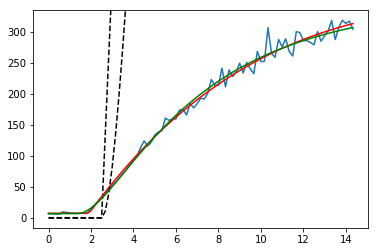

In [5]:
data = egfp_lipo[40]
sigma = np.sqrt(data)
time = np.arange(0,data.size)*10/60
result2 = twostage_model.fit(data, t=time, t0=2.5, ktl=800, delta=0.07, beta=0.05, weights=1/sigma)
result3 = threestage_model.fit(data, t=time, t0=2.5, ktl=800, km=1,delta=0.07, beta=0.05, weights=1/sigma)
plt.figure()
plt.plot(time,data)
plt.plot(time,result2.init_fit, 'k--')
plt.plot(time, result2.best_fit, 'r-')
plt.plot(time,result3.init_fit, 'k--')
plt.plot(time, result3.best_fit, 'g-')
plt.ylim((-0.05*data.max(),data.max()*1.05))
print(result2.fit_report())
print(result3.fit_report())

In [6]:
# cluster analysis to find the onset for fluorescence
# normalize the data
time_norm=(time-time.min())/50/(time.max()-time.min())
t0cluster_list=[]
for data in egfp_lipo:
    data_norm=(data-data.min())/(data.max()-data.min())
    data_diff_norm=np.gradient(data_norm)
    # combine the data
    X = np.vstack((time_norm,data_norm,data_diff_norm)).T
    # generate the linkage matrix
    Z = ch.linkage(X, method='single',metric='cityblock')
    tree = ch.cut_tree(Z, height=0.003).flatten()
    t0cluster_list.append(tree[tree==0].size)
t0cluster_list=np.array(t0cluster_list)
# convert to hours
t0cluster_list=(t0cluster_list)*10/60

data set 0 t0_guess 2.474891466478254
data set 1 t0_guess 2.334826397717321
data set 2 t0_guess 1.8504847793332455
data set 3 t0_guess 2.8005734281521617
data set 4 t0_guess 2.209422449840795
data set 5 t0_guess 2.8907120633054046
data set 6 t0_guess 4.069517039403621
data set 7 t0_guess 2.711519209340019
data set 8 t0_guess 3.2047740041397375
data set 9 t0_guess 2.795825261377614
data set 10 t0_guess 3.1008090310442147
data set 11 t0_guess 2.126190181518152
data set 12 t0_guess 2.280841319992979
data set 13 t0_guess 1.8655190519051907
data set 14 t0_guess 2.498781002998092
data set 15 t0_guess 2.538663067456171
data set 16 t0_guess 1.9937043763024709
data set 17 t0_guess 5.7405678642714575
data set 18 t0_guess 4.975690646056282
data set 19 t0_guess 1.8235929174067493
data set 20 t0_guess 2.9135020196000534
data set

/Users/hstrey/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


 21 t0_guess 4.459182857142857
data set 22 t0_guess 2.398653095098614
data set 23 t0_guess 1.598956537486418
data set 24 t0_guess 3.0011077993045205
data set 25 t0_guess 2.0334946860563026
data set 26 t0_guess 2.567844170031798
data set 27 t0_guess 6.859320866141732
data set 28 t0_guess 2.7951685875429133
data set 29 t0_guess 2.7128455062984496
data set 30 t0_guess 1.8909222412292548
data set 31 t0_guess 3.4008064516129037
data set 32 t0_guess 3.5496276554654305
data set 33 t0_guess 1.9824941706824186
data set 34 t0_guess 2.0184669328419327
data set 35 t0_guess 2.6810330515573835
data set 36 t0_guess 1.9672279423412007
data set 37 t0_guess 4.810269292604501
data set 38 t0_guess 3.463166696854435
data set 39 t0_guess 2.605595521992581
data set 40 t0_guess 2.354193093727978
data set 41 t0_guess 3.141167986276062
data set 42 t0_guess 4.44241990167825
data set 43 t0_guess 1.8499838764884973
data set 44 t0_guess 2.6217268802544877
data set 45 t0_guess 2.6442370050796744
data set 46 t0_guess

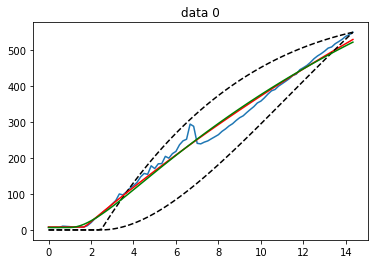

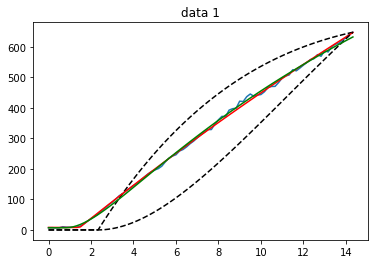

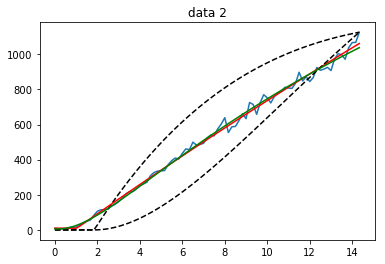

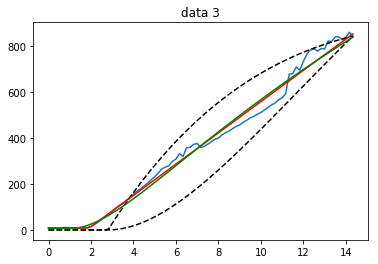

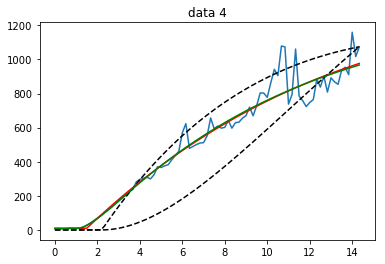

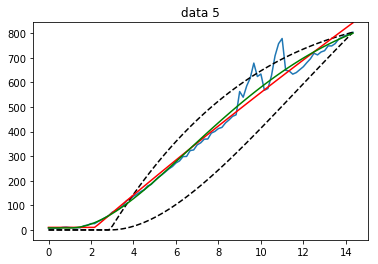

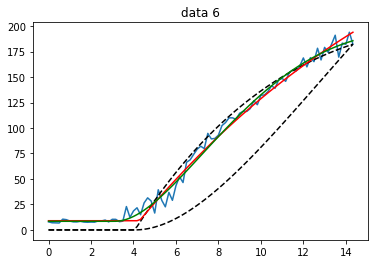

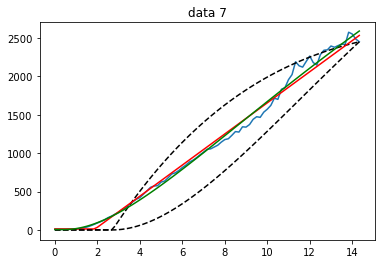

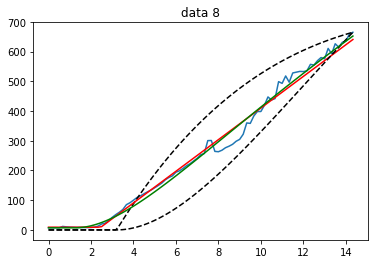

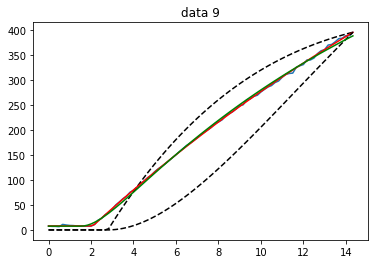

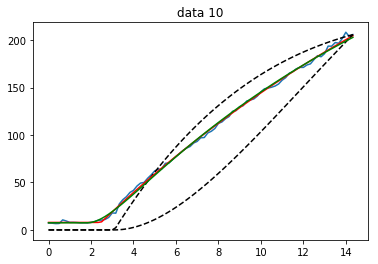

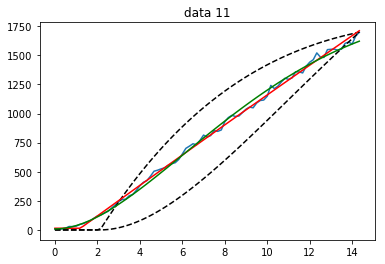

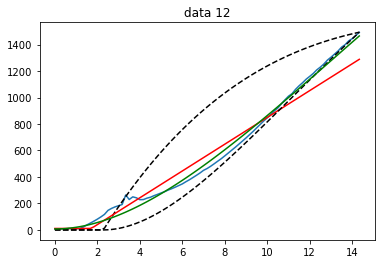

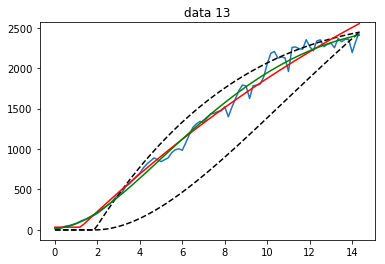

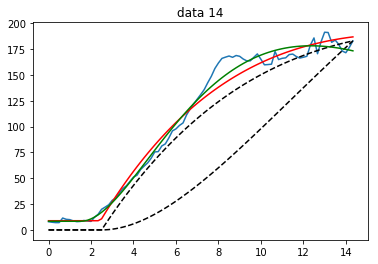

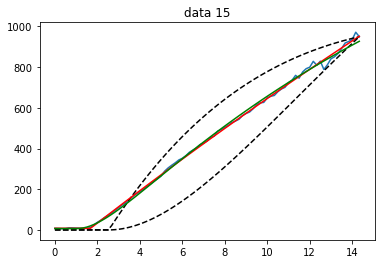

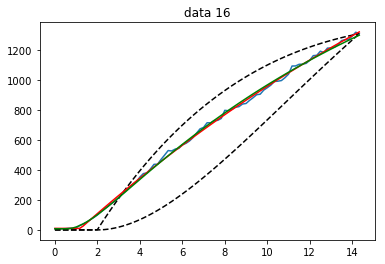

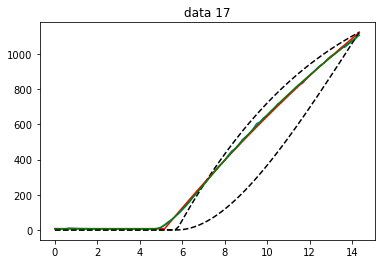

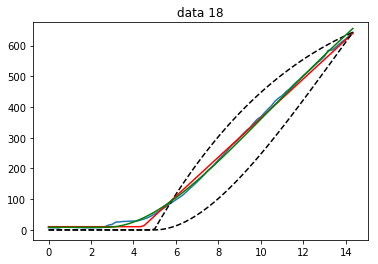

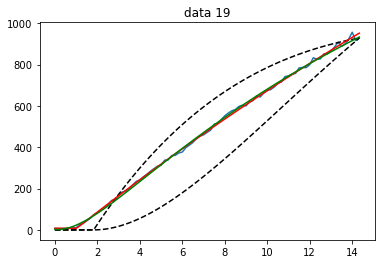

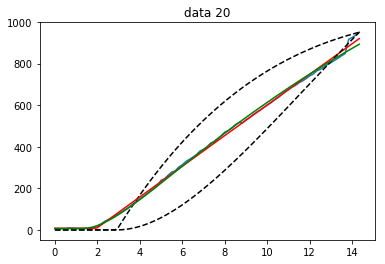

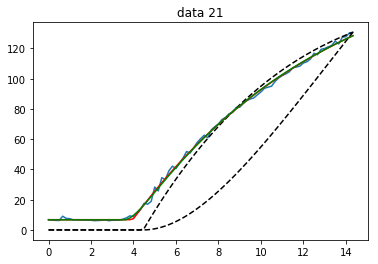

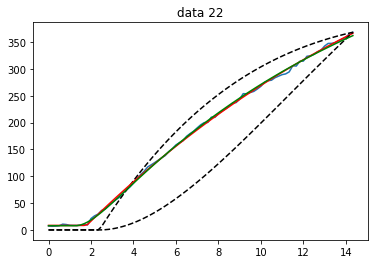

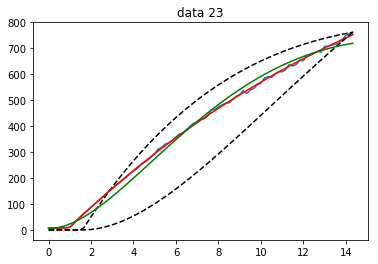

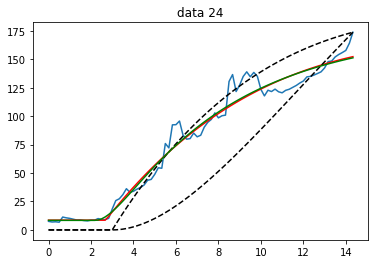

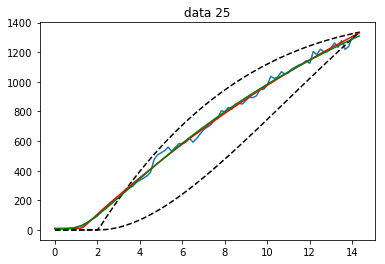

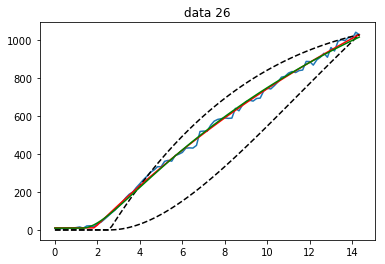

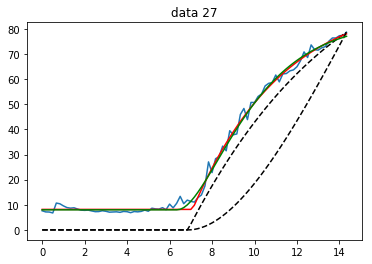

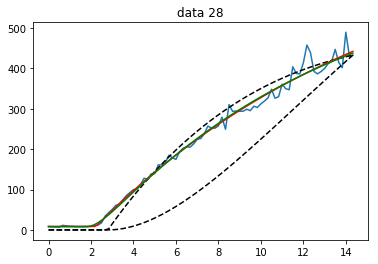

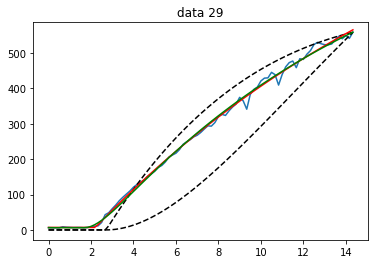

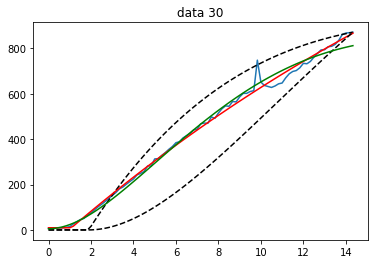

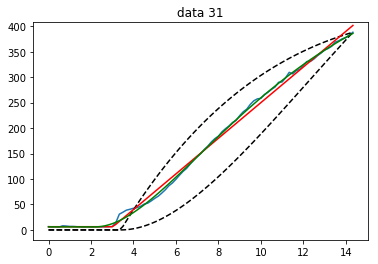

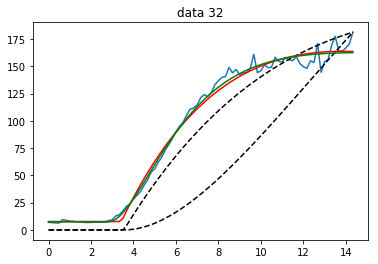

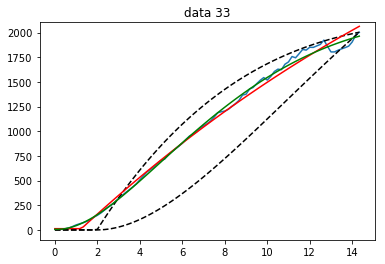

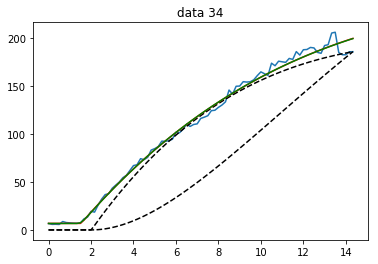

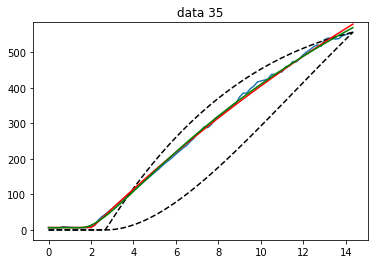

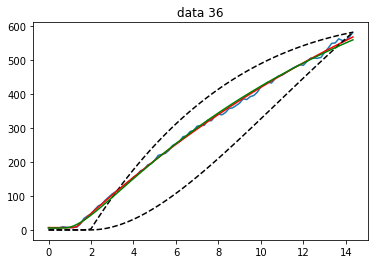

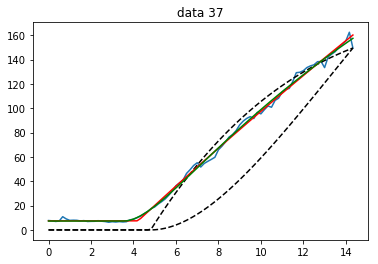

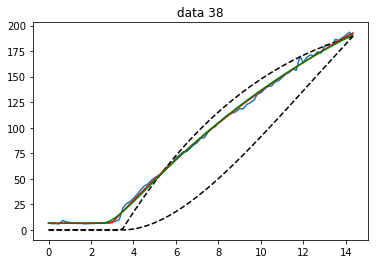

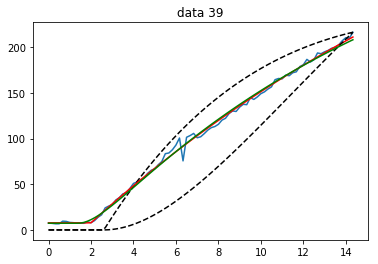

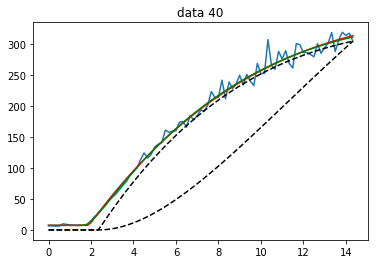

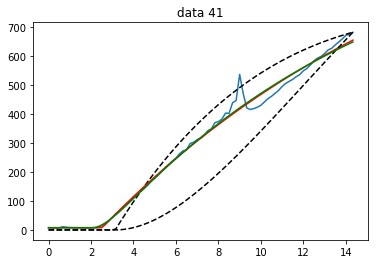

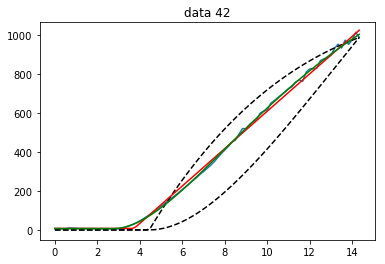

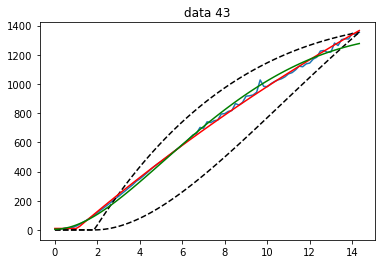

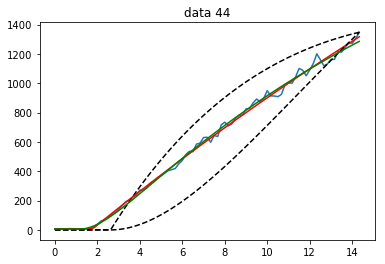

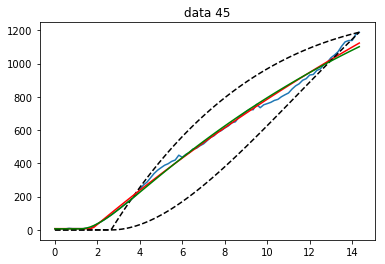

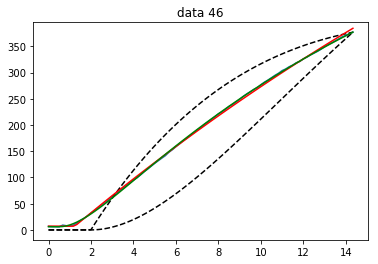

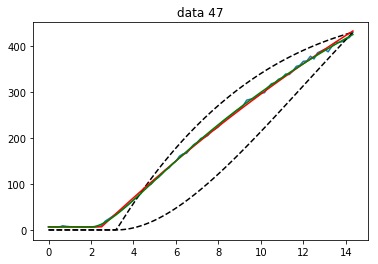

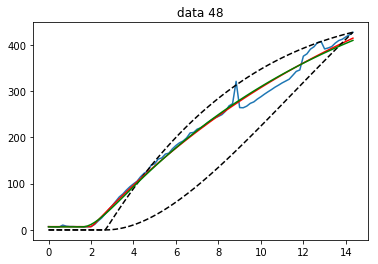

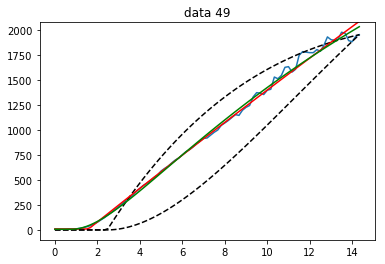

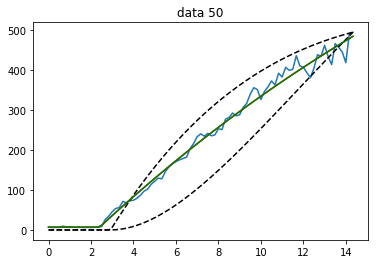

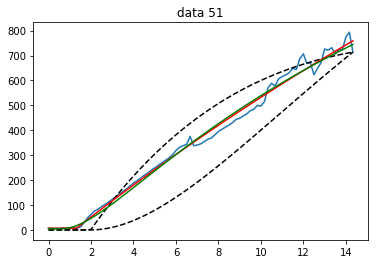

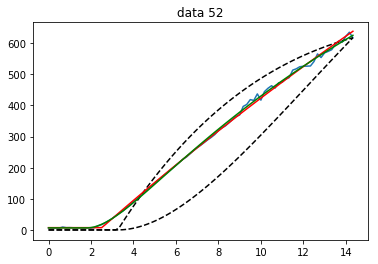

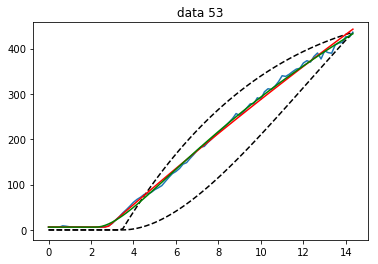

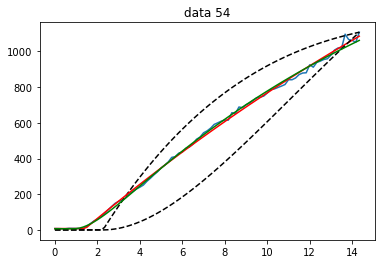

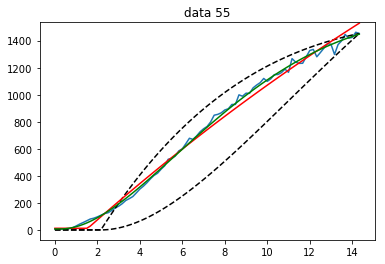

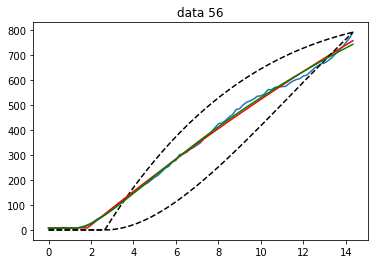

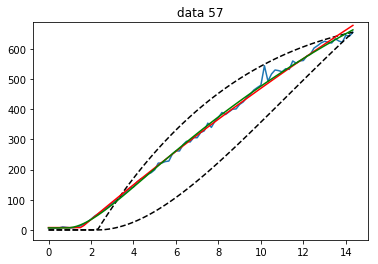

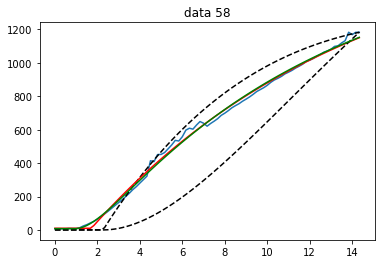

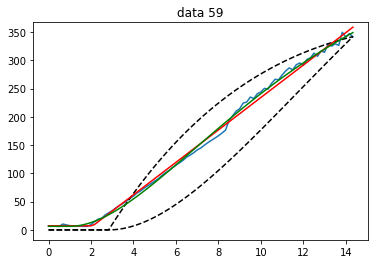

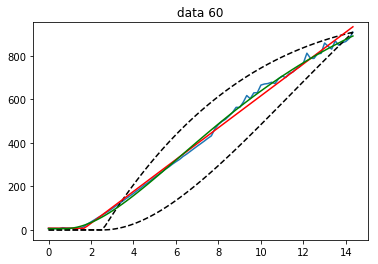

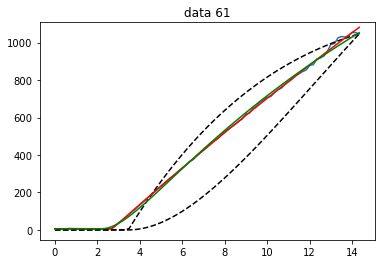

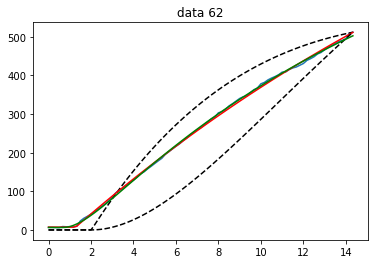

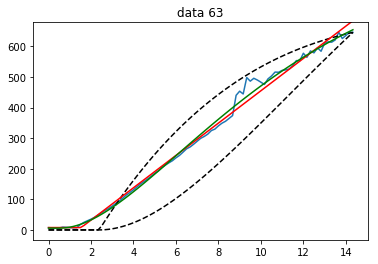

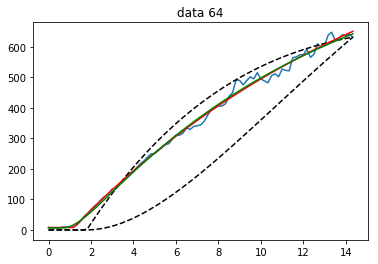

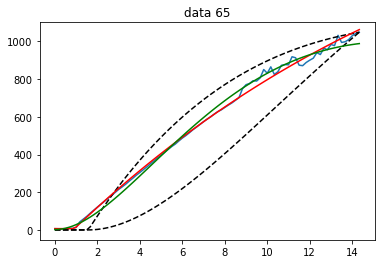

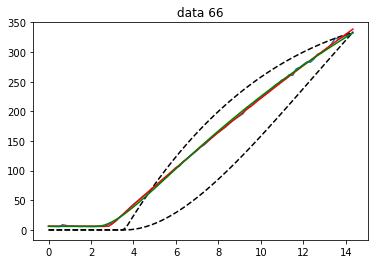

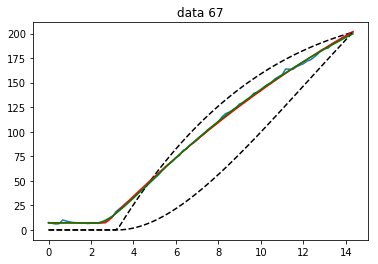

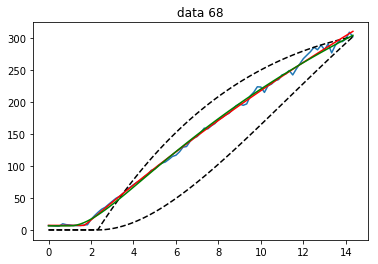

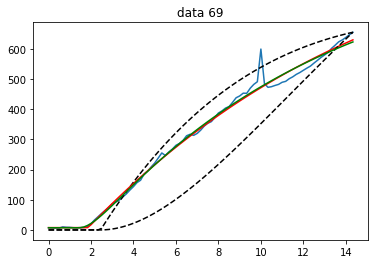

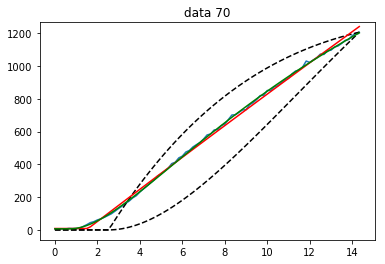

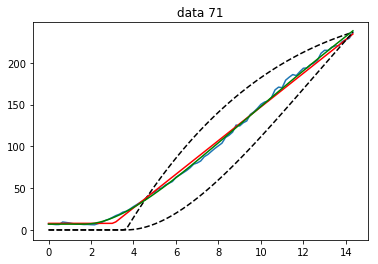

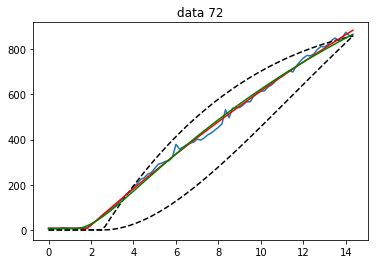

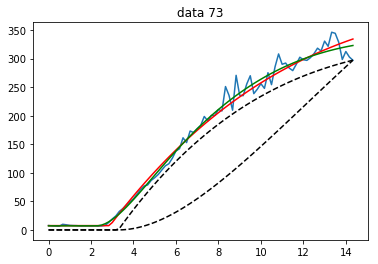

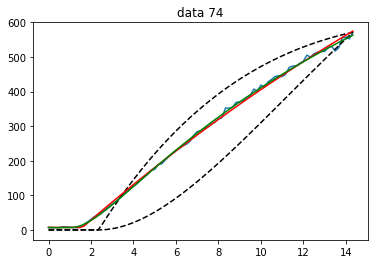

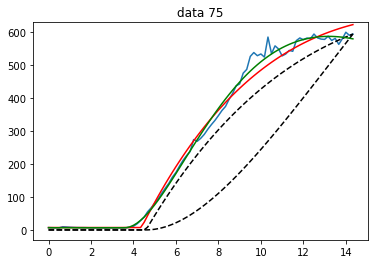

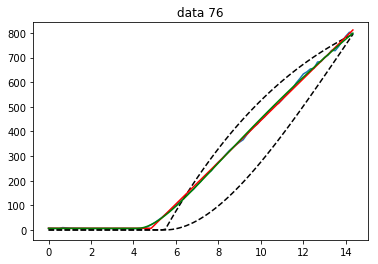

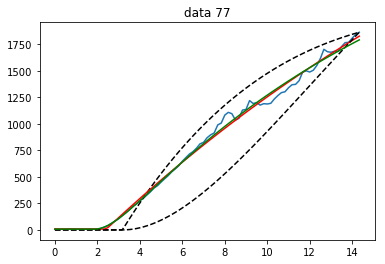

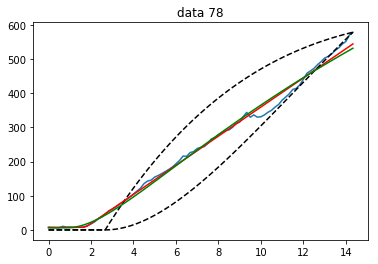

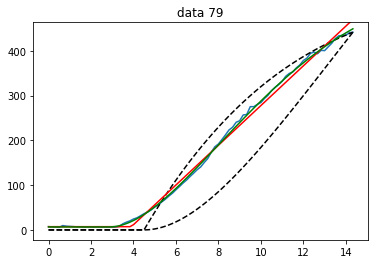

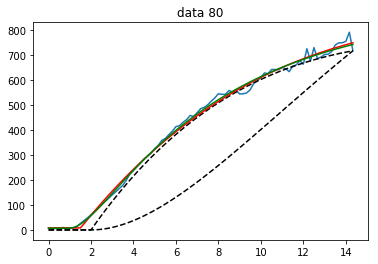

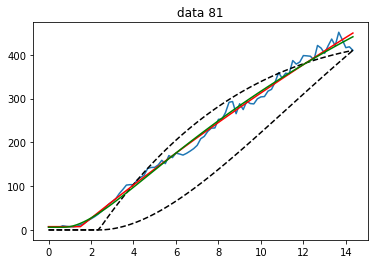

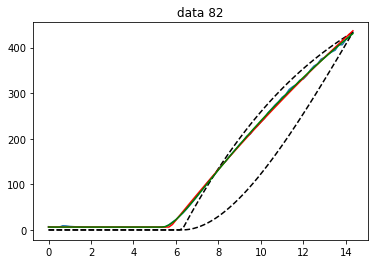

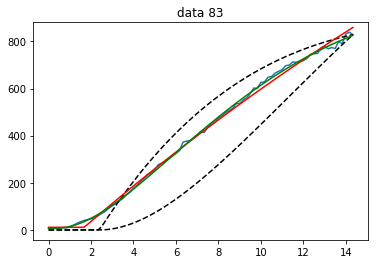

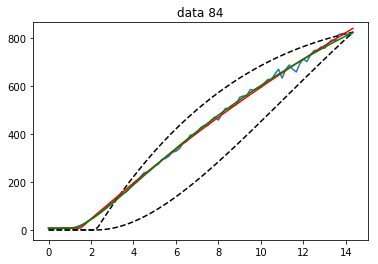

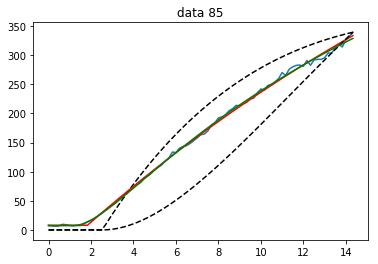

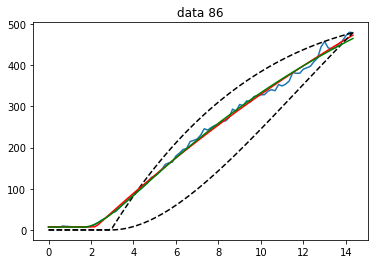

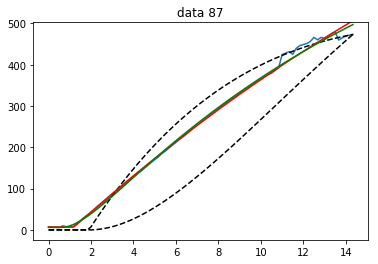

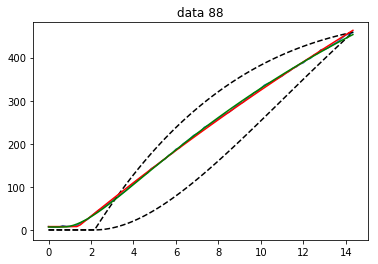

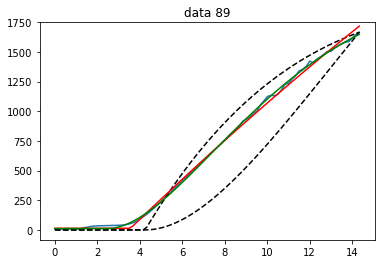

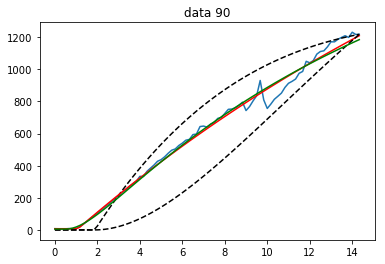

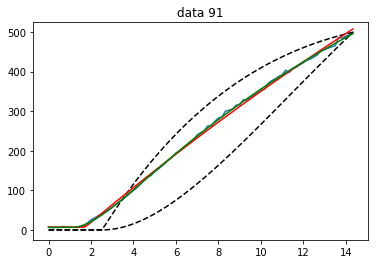

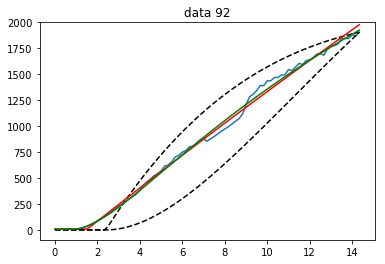

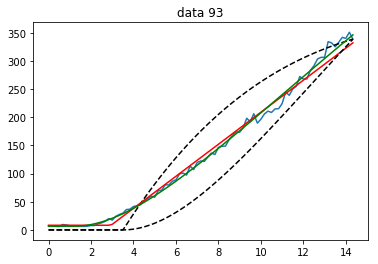

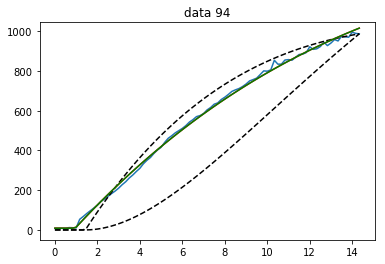

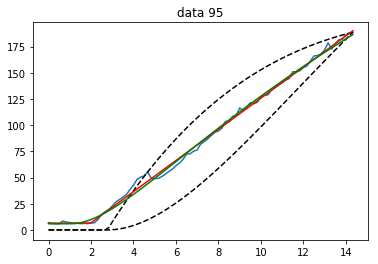

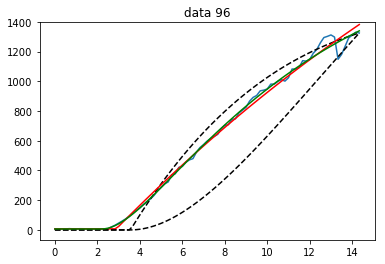

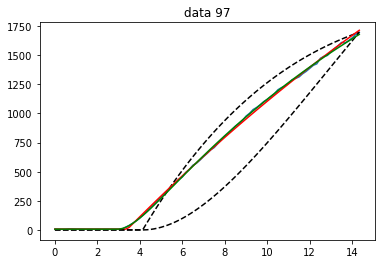

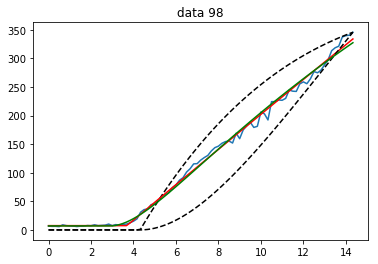

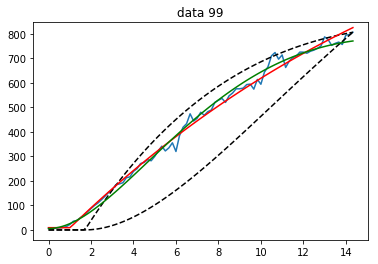

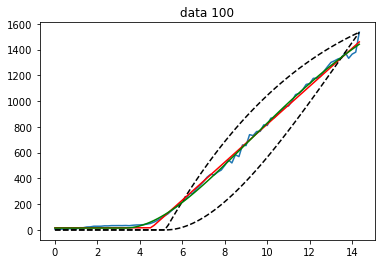

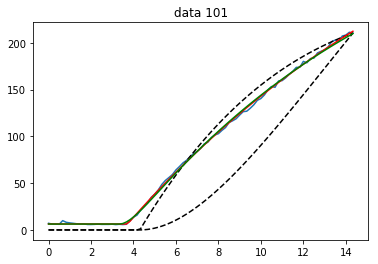

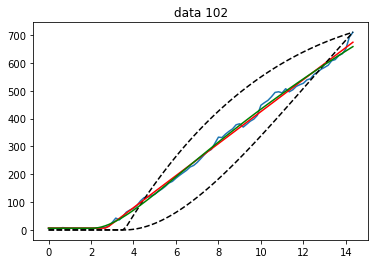

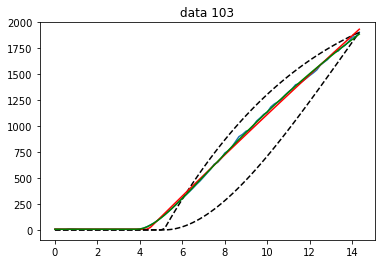

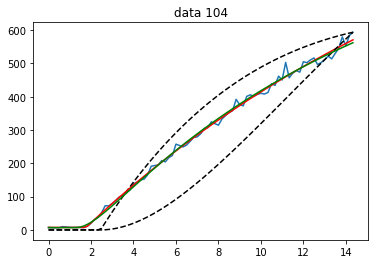

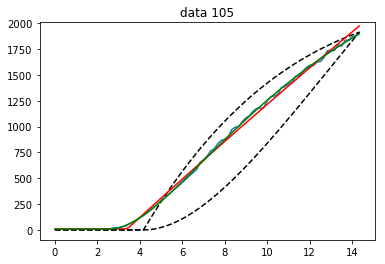

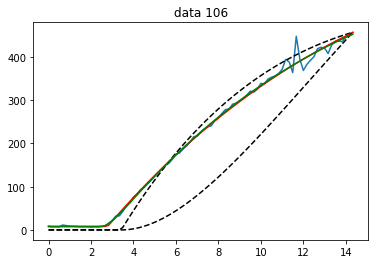

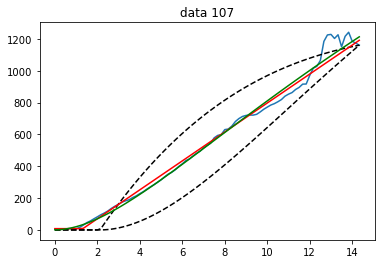

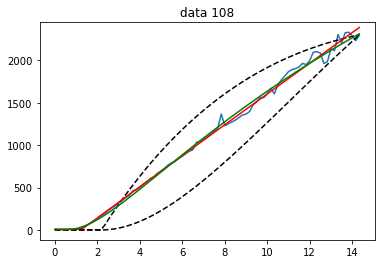

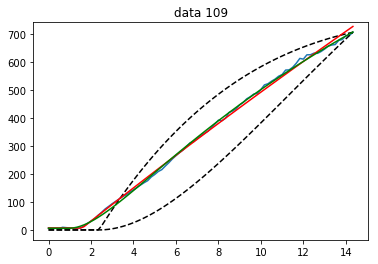

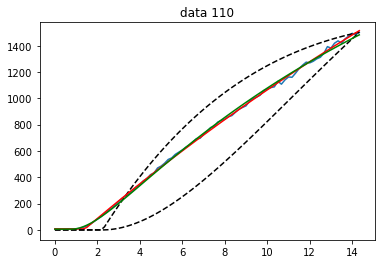

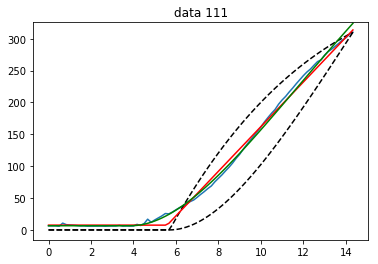

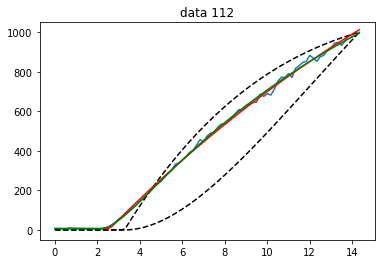

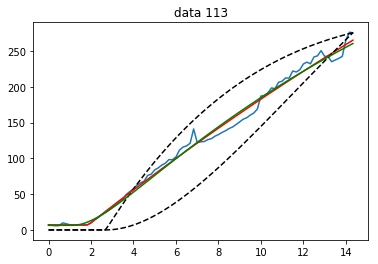

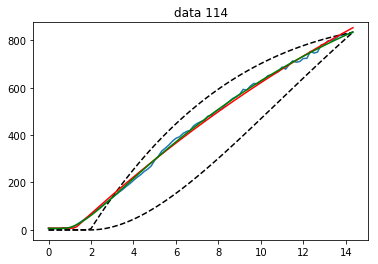

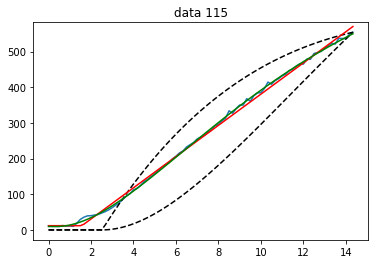

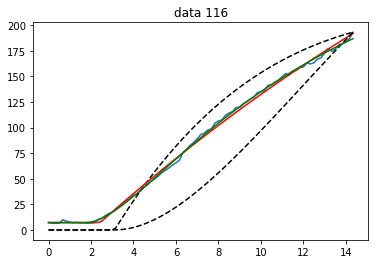

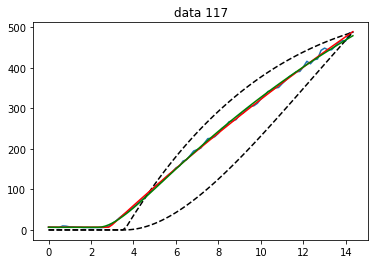

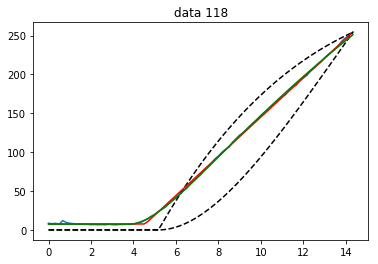

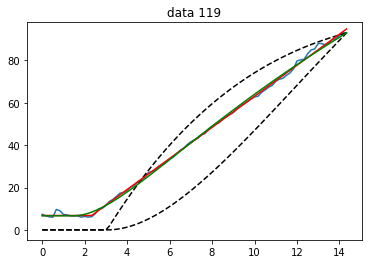

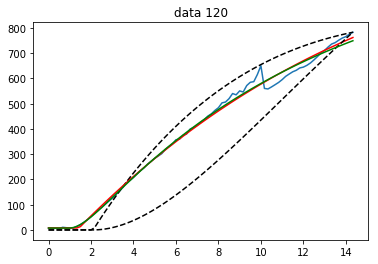

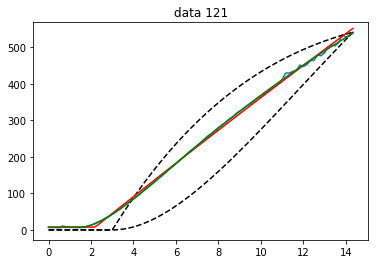

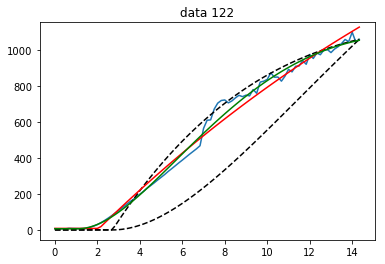

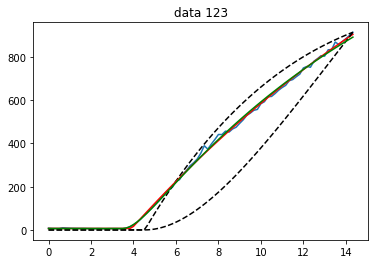

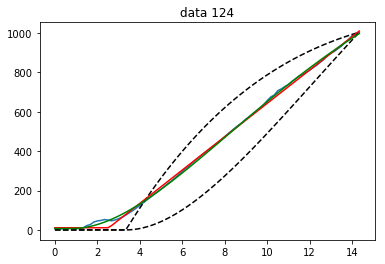

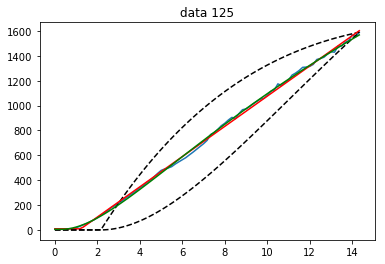

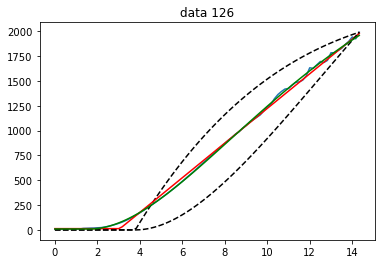

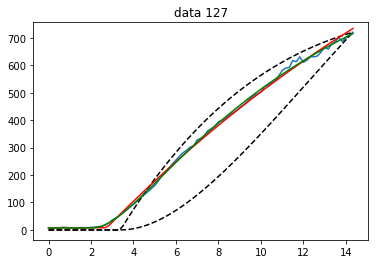

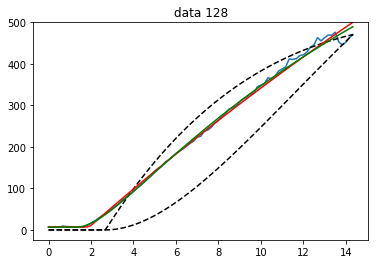

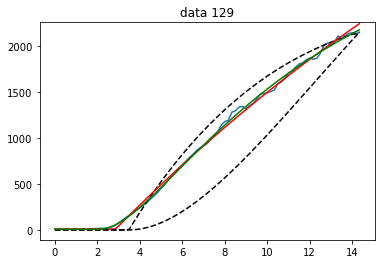

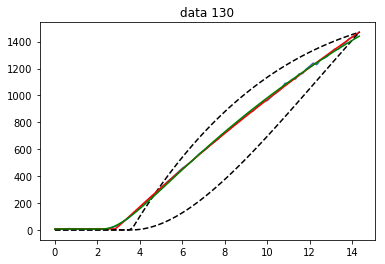

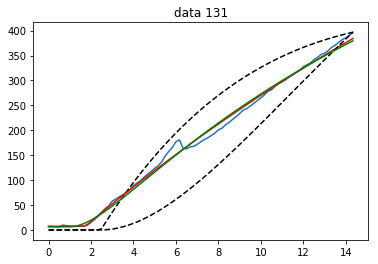

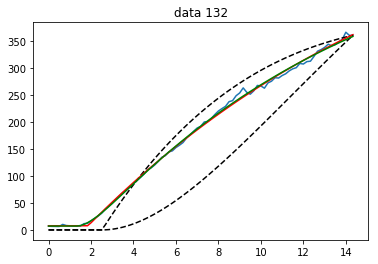

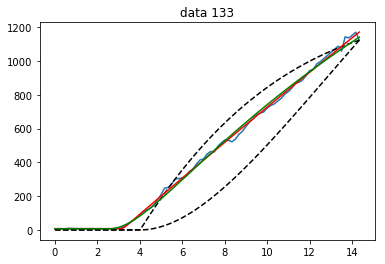

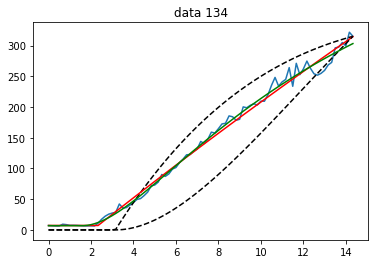

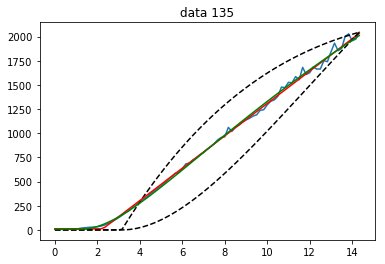

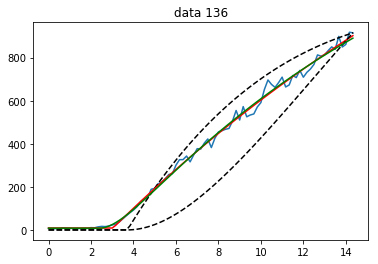

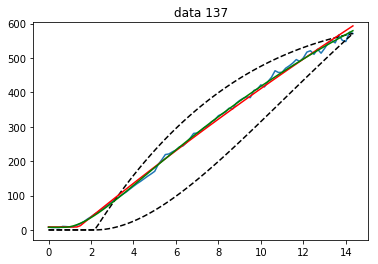

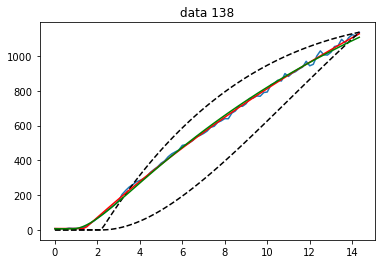

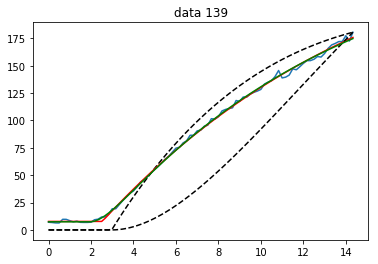

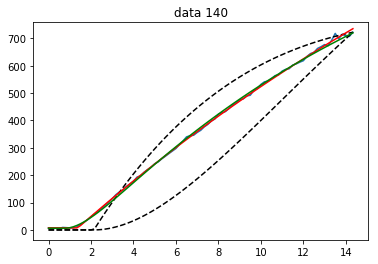

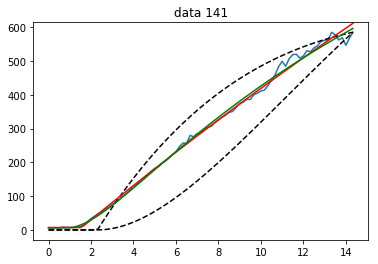

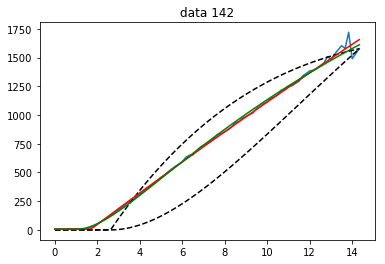

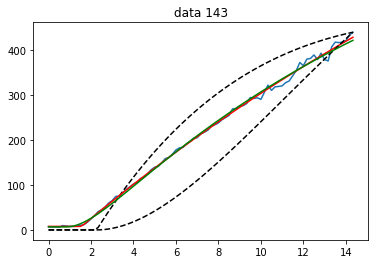

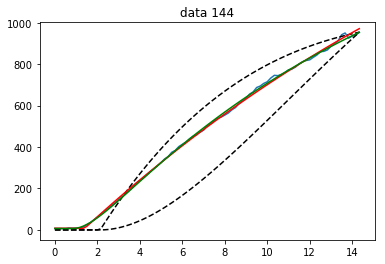

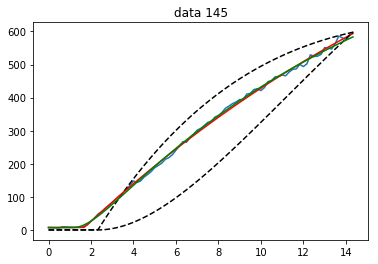

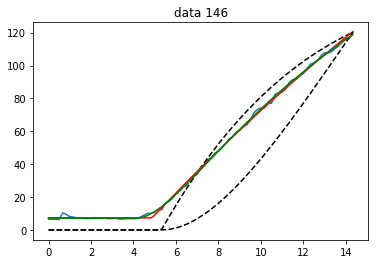

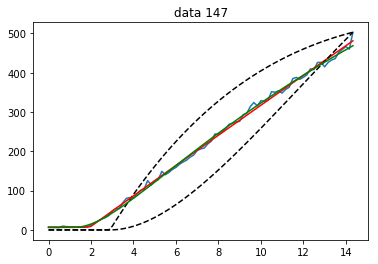

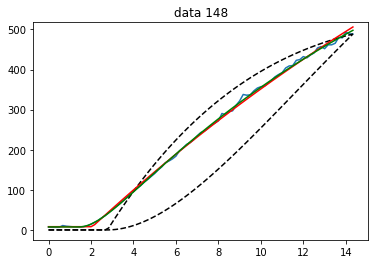

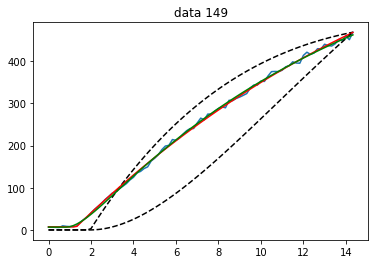

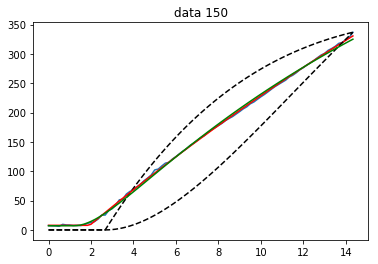

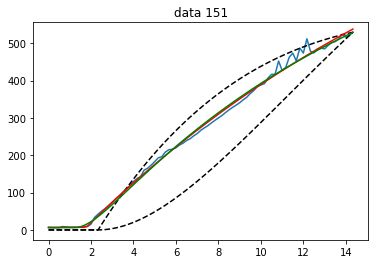

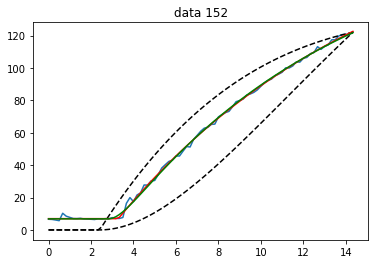

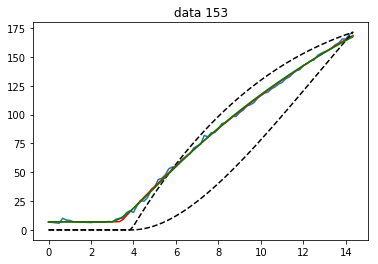

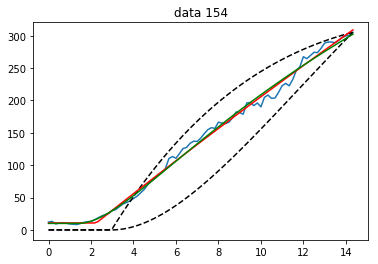

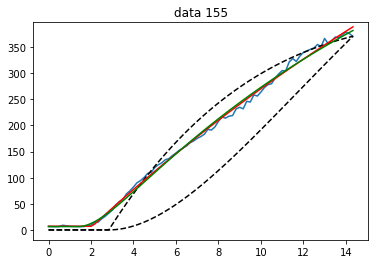

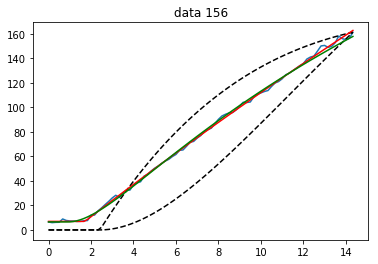

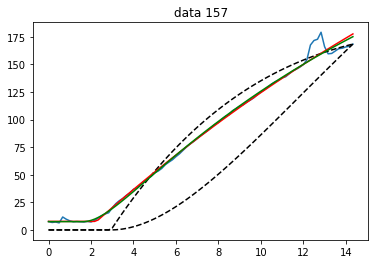

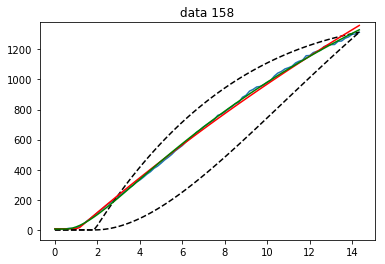

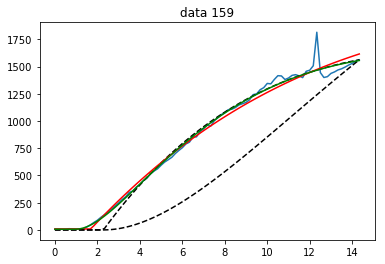

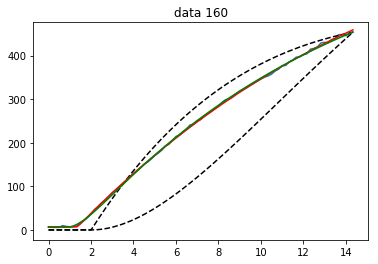

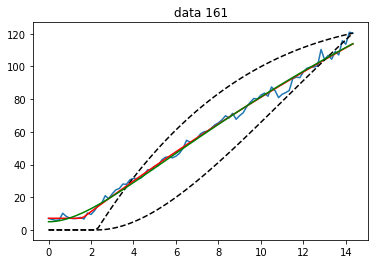

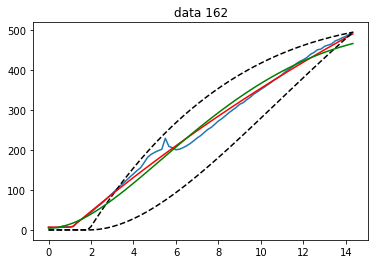

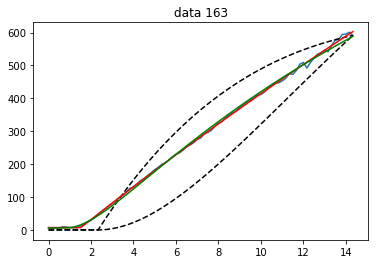

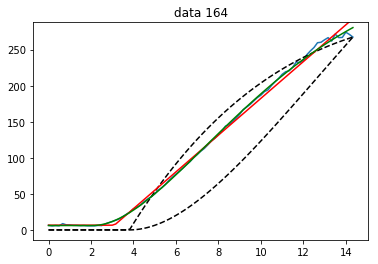

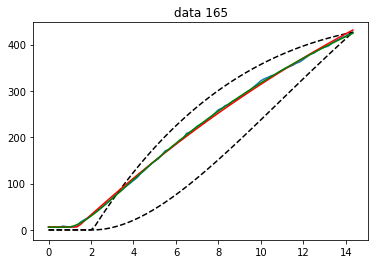

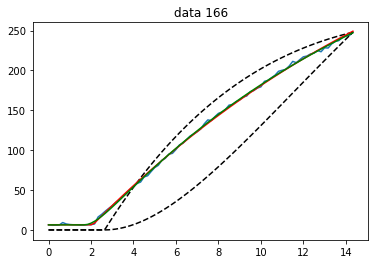

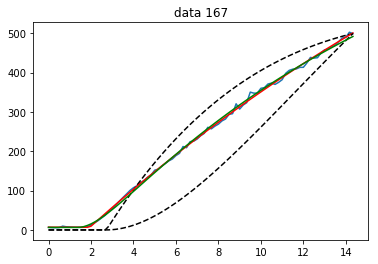

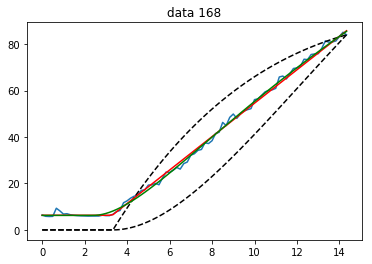

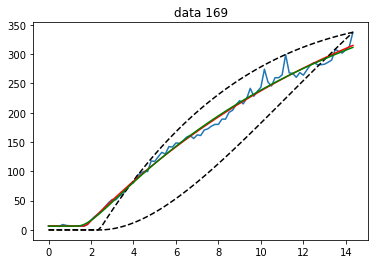

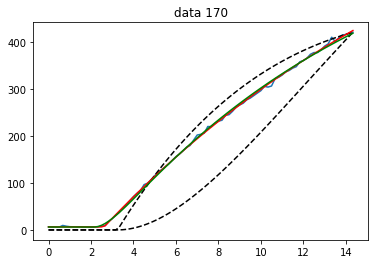

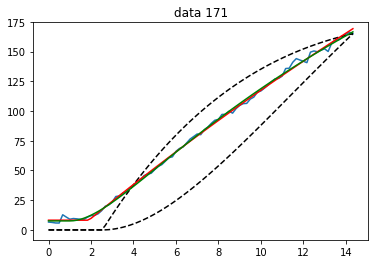

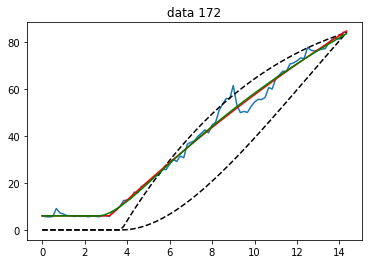

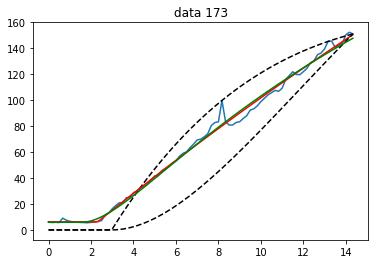

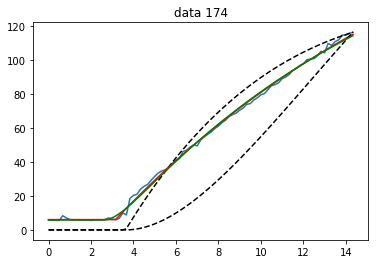

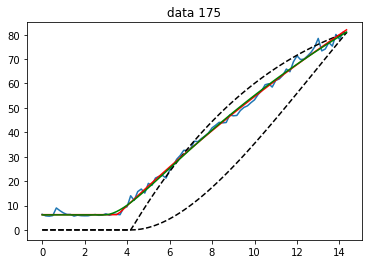

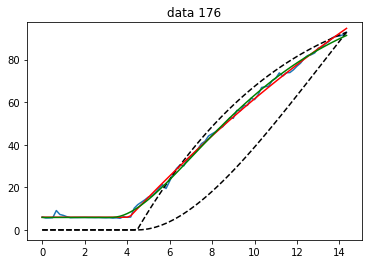

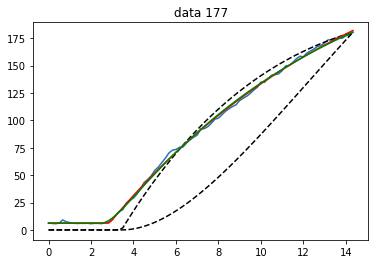

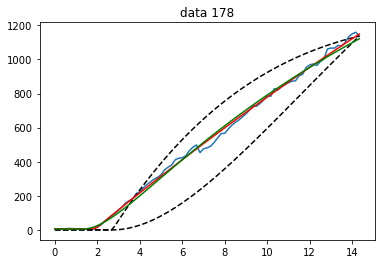

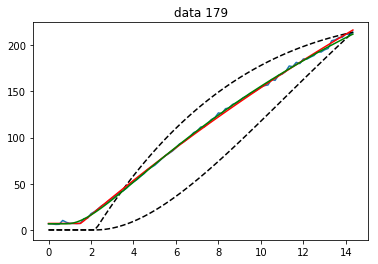

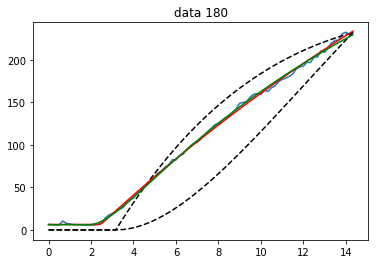

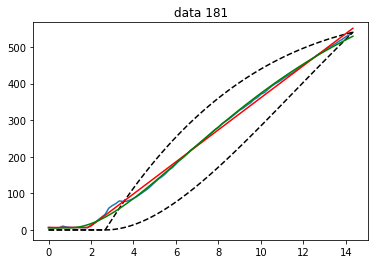

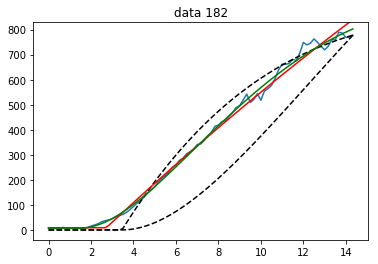

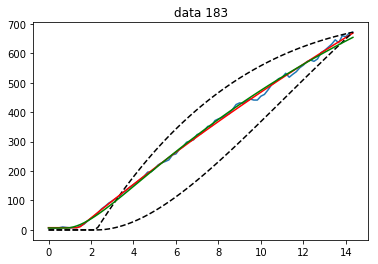

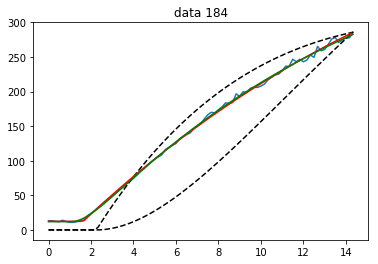

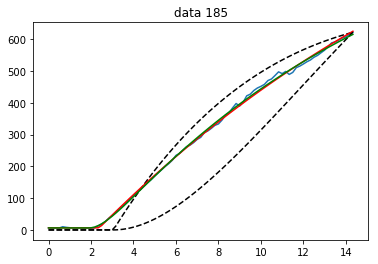

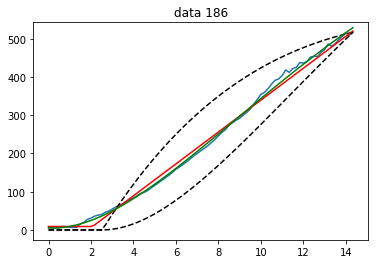

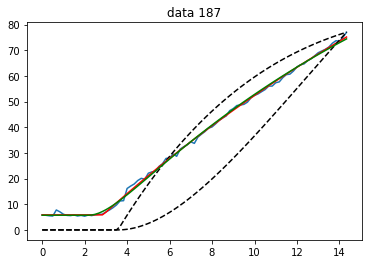

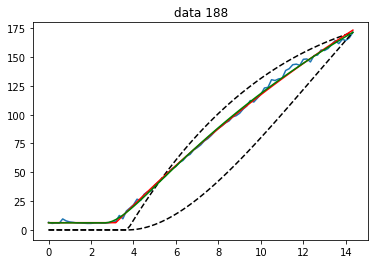

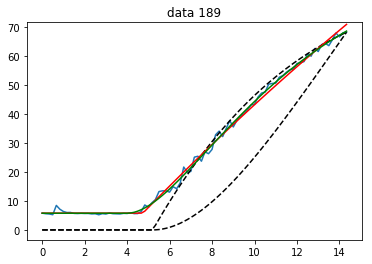

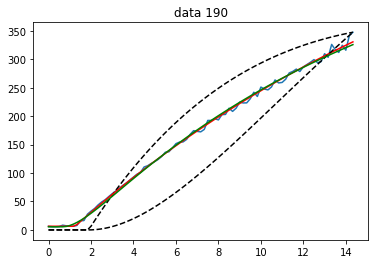

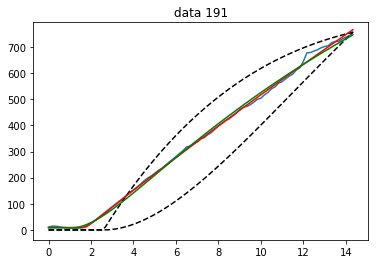

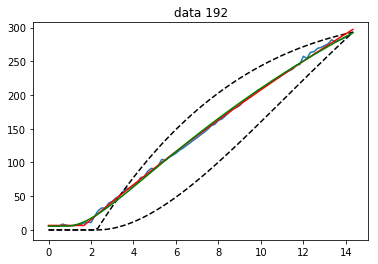

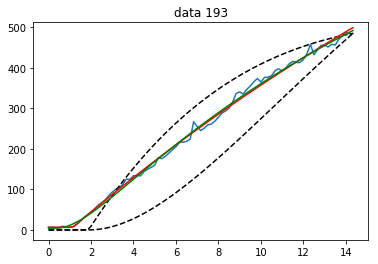

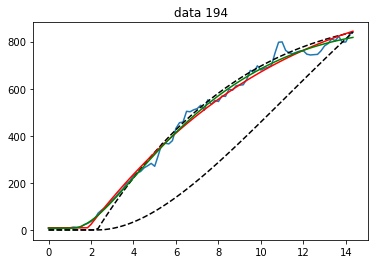

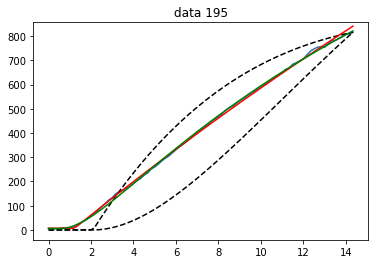

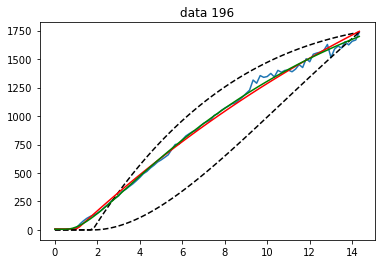

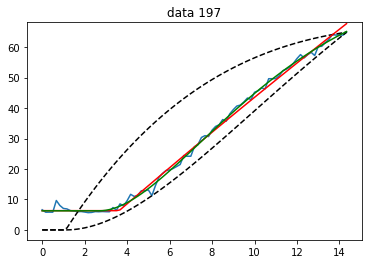

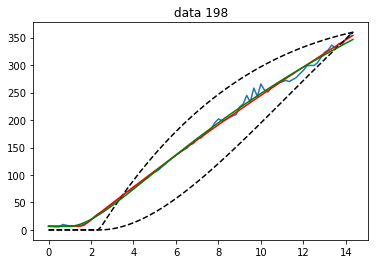

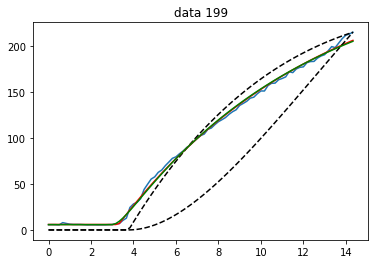

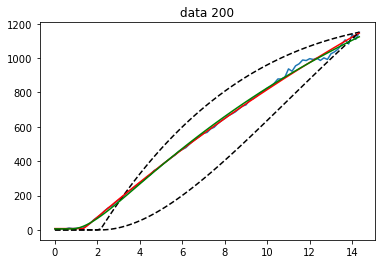

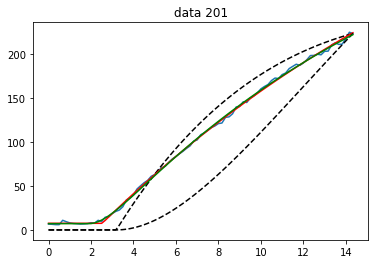

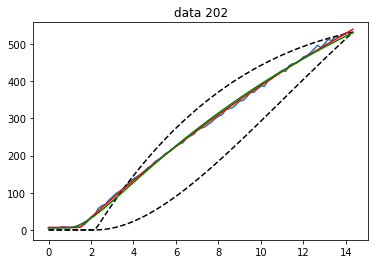

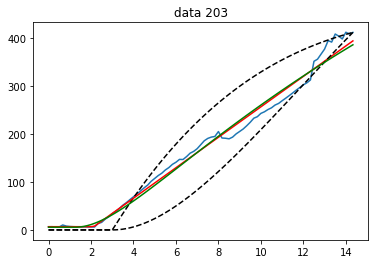

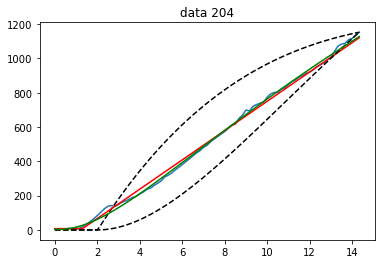

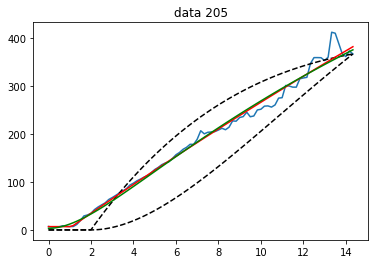

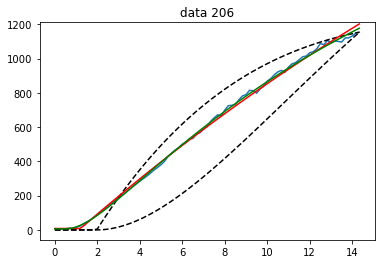

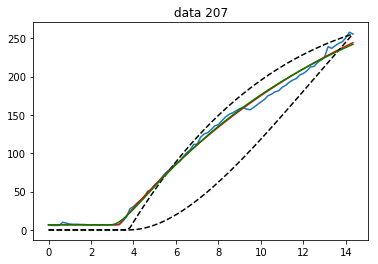

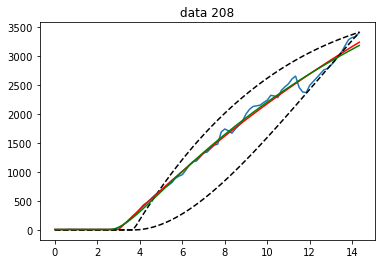

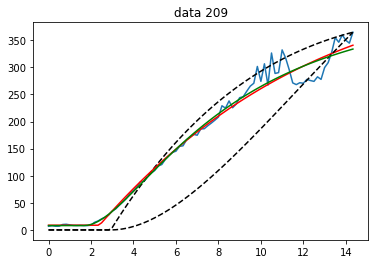

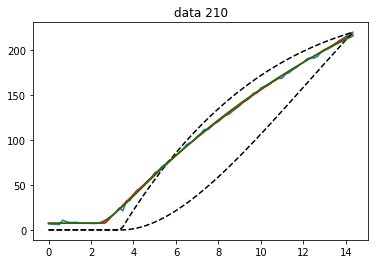

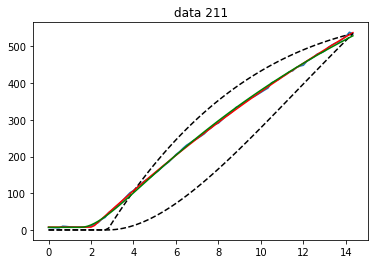

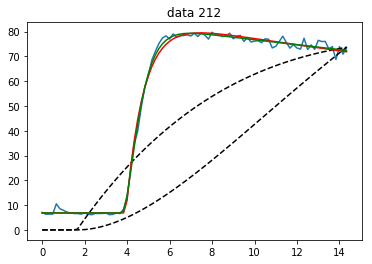

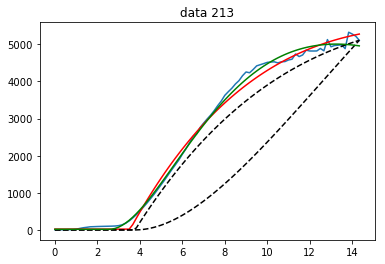

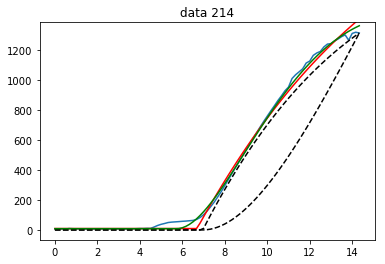

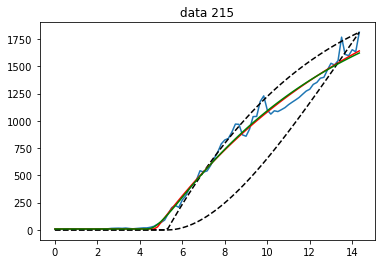

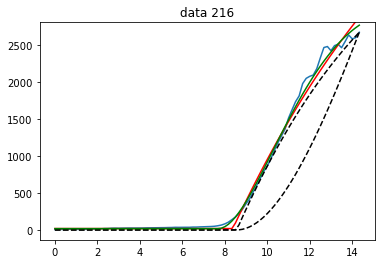

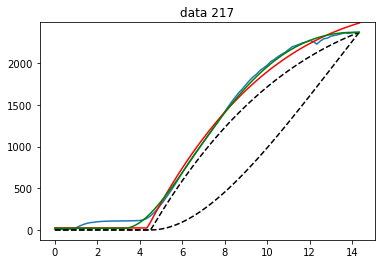

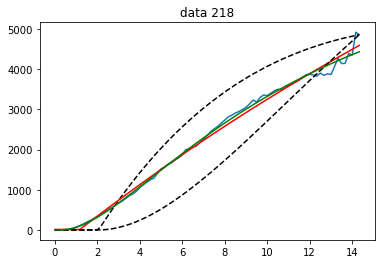

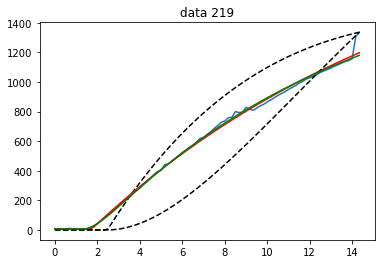

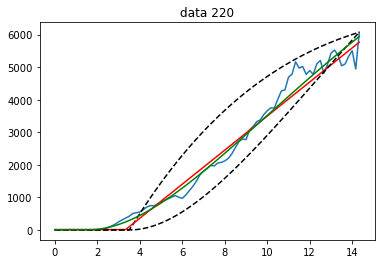

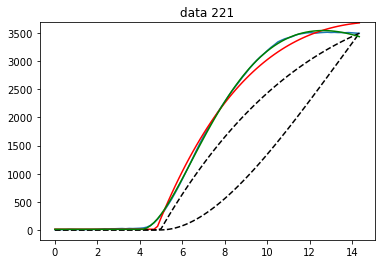

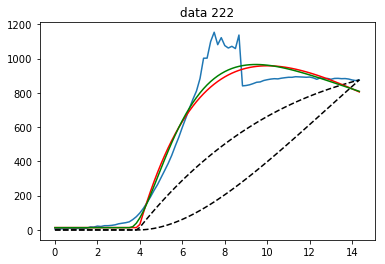

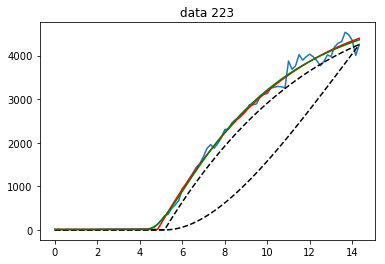

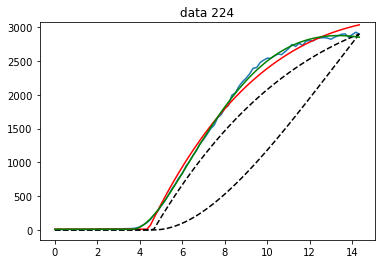

In [7]:
# two stage model
t0_list=[]
ktl_list=[]
delta_list=[]
beta_list=[]
t0_std_list=[]
ktl_std_list=[]
delta_std_list=[]
beta_std_list=[]
red_chi2_list=[]

# three stage model
t0_list3=[]
ktl_list3=[]
km_list3=[]
delta_list3=[]
beta_list3=[]
t0_std_list3=[]
ktl_std_list3=[]
km_std_list3=[]
delta_std_list3=[]
beta_std_list3=[]
red_chi2_list3=[]

for data,t0guess,i in zip(egfp_lipo,t0cluster_list,range(t0cluster_list.size)):
    sigma = np.sqrt(data)
    time = np.arange(0,data.size)*10/60
    # lets estimate the parameters
    # to estimate t0 we take I_max-I_min and estimate t for which I=I_min+0.1(I_max-Imin)
    # this can be done by interpolation.  The advantage is that the guess for t0 is greater
    # than the actual value - fits seems to converge better
    delta_I=data.max()-data.min()
    t0guess = interp1d(data,time)(data.min()+0.07*delta_I)
    print("data set",i,"t0_guess",t0guess)
    delta_t=time[-1]-t0guess
    
    two=twostage(np.array([delta_t]),0,1,0.07,0.05)
    ktl2=data[-1]/two[0]
    
    three=threestage(np.array([delta_t]),0,1,0.03,0.07,0.05)
    ktl3=data[-1]/three[0]
    
    result2 = twostage_model.fit(data, t=time, t0=t0guess, ktl=ktl2, delta=0.07, beta=0.05, weights=1/sigma)
    result3 = threestage_model.fit(data, t=time, t0=t0guess, ktl=ktl3, km=0.03,delta=0.07, beta=0.05, weights=1/sigma)

    plt.figure()
    plt.title("data "+str(i))
    plt.plot(time,data)
    plt.plot(time,result2.init_fit, 'k--')
    plt.plot(time, result2.best_fit, 'r-')
    plt.plot(time,result3.init_fit, 'k--')
    plt.plot(time, result3.best_fit, 'g-')
    plt.ylim((-0.05*data.max(),data.max()*1.05))
    
    if result2:
        t0_list.append(np.abs(result2.values['t0']))
        ktl_list.append(np.abs(result2.values['ktl']))
        delta_list.append(np.abs(result2.values['delta']))
        beta_list.append(np.abs(result2.values['beta']))
        red_chi2_list.append(result2.redchi)

        t0_std_list.append(result2.covar[0][0])
        ktl_std_list.append(result2.covar[1][1])
        delta_std_list.append(result2.covar[2][2])
        beta_std_list.append(result2.covar[3][3])
    
    if result3:
        t0_list3.append(np.abs(result3.values['t0']))
        ktl_list3.append(np.abs(result3.values['ktl']))
        km_list3.append(np.abs(result3.values['km']))
        delta_list3.append(np.abs(result3.values['delta']))
        beta_list3.append(np.abs(result3.values['beta']))
        red_chi2_list3.append(result3.redchi)

        t0_std_list3.append(result3.covar[0][0])
        ktl_std_list3.append(result3.covar[1][1])
        km_std_list3.append(result3.covar[2][2])
        delta_std_list3.append(result3.covar[3][3])
        beta_std_list3.append(result3.covar[4][4])
    
t0_list=np.array(t0_list)
ktl_list=np.array(ktl_list)
delta_list=np.array(delta_list)
beta_list=np.array(beta_list)
t0_std_list=np.array(t0_std_list)
ktl_std_list=np.array(ktl_std_list)
delta_std_list=np.array(delta_std_list)
beta_std_list=np.array(beta_std_list)

t0_list3=np.array(t0_list3)
ktl_list3=np.array(ktl_list3)
km_list3=np.array(km_list3)
delta_list3=np.array(delta_list3)
beta_list3=np.array(beta_list3)
t0_std_list3=np.array(t0_std_list3)
ktl_std_list3=np.array(ktl_std_list3)
km_std_list3=np.array(km_std_list3)
delta_std_list3=np.array(delta_std_list3)
beta_std_list3=np.array(beta_std_list3)

red_chi2_list=np.array(red_chi2_list)
red_chi2_list3=np.array(red_chi2_list3)


1.43504300596 0.937172137401
4.19073787343 2.10097956727
[ 9.79101408  6.48764741  0.99512758  0.36149319  0.11757142  0.04826664]
[ 6.01457375  3.36359445  0.83244161  0.35825913  0.14704589  0.05076571]


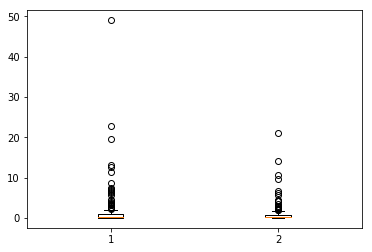

In [8]:
plt.boxplot([red_chi2_list,red_chi2_list3])
print(red_chi2_list.mean(),red_chi2_list3.mean())
print(red_chi2_list.std(),red_chi2_list3.std())
print(np.percentile(red_chi2_list,[97.5,95,75,50,25,2.5]))
print(np.percentile(red_chi2_list3,[97.5,95,75,50,25,2.5]))

In [9]:
print(np.argmax(red_chi2_list),red_chi2_list.max())
print(np.argmax(red_chi2_list3),red_chi2_list3.max())

220 49.0370500921
220 20.9665562501


In [10]:
# cleaning up the data by setting a threshold for redchi2
threshold2 = 150
threshold3 = 150
ktl_list_clean=ktl_list[red_chi2_list<threshold2]
delta_list_clean=delta_list[red_chi2_list<threshold2]
beta_list_clean=beta_list[red_chi2_list<threshold2]
t0_list_clean=t0_list[red_chi2_list<threshold2]
ktl_std_list_clean=ktl_std_list[red_chi2_list<threshold2]
delta_std_list_clean=delta_std_list[red_chi2_list<threshold2]
beta_std_list_clean=beta_std_list[red_chi2_list<threshold2]
t0_std_list_clean=t0_std_list[red_chi2_list<threshold2]

ktl_list3_clean=ktl_list3[red_chi2_list3<threshold3]
km_list3_clean=km_list3[red_chi2_list3<threshold3]
delta_list3_clean=delta_list3[red_chi2_list3<threshold3]
beta_list3_clean=beta_list3[red_chi2_list3<threshold3]
t0_list3_clean=t0_list3[red_chi2_list3<threshold3]
km_std_list3_clean=km_std_list3[red_chi2_list3<threshold3]
ktl_std_list3_clean=ktl_std_list3[red_chi2_list3<threshold3]
delta_std_list3_clean=delta_std_list3[red_chi2_list3<threshold3]
beta_std_list3_clean=beta_std_list3[red_chi2_list3<threshold3]
t0_std_list3_clean=t0_std_list3[red_chi2_list3<threshold3]


In [11]:
print(ktl_list.size,ktl_list_clean.size)
print(ktl_list3.size,ktl_list3_clean.size)

225 225
225 225


95.6557873656 25698.7263608


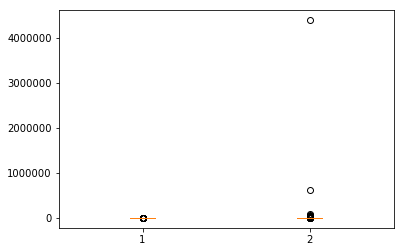

In [12]:
plt.boxplot([ktl_list_clean,ktl_list3_clean])
print(ktl_list_clean.mean(),ktl_list3_clean.mean())

(array([ 223.,    1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    1.]),
 array([  2.00173785e+01,   4.38697536e+05,   8.77375054e+05,
          1.31605257e+06,   1.75473009e+06,   2.19340761e+06,
          2.63208513e+06,   3.07076264e+06,   3.50944016e+06,
          3.94811768e+06,   4.38679520e+06]),
 <a list of 10 Patch objects>)

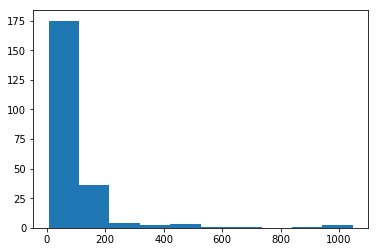

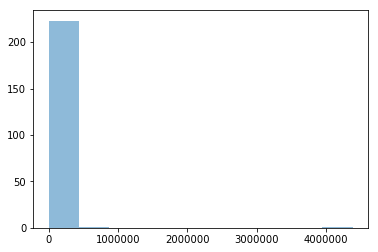

In [13]:
plt.figure()
plt.hist(ktl_list_clean)
plt.figure()
plt.hist(ktl_list3_clean,alpha=0.5)

(array([ 221.,    0.,    2.,    1.,    0.,    0.,    0.,    0.,    0.,    1.]),
 array([  2.08130941e-03,   2.18641439e-01,   4.35201569e-01,
          6.51761699e-01,   8.68321829e-01,   1.08488196e+00,
          1.30144209e+00,   1.51800222e+00,   1.73456235e+00,
          1.95112248e+00,   2.16768261e+00]),
 <a list of 10 Patch objects>)

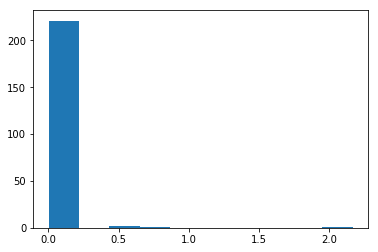

In [14]:
plt.figure()
plt.hist(km_list3_clean)

{'boxes': [<matplotlib.lines.Line2D at 0x127426470>,
 'caps': [<matplotlib.lines.Line2D at 0x12742deb8>,
 'fliers': [<matplotlib.lines.Line2D at 0x127438780>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x127433898>,
 'whiskers': [<matplotlib.lines.Line2D at 0x127426e48>,
  <matplotlib.lines.Line2D at 0x127440fd0>]}

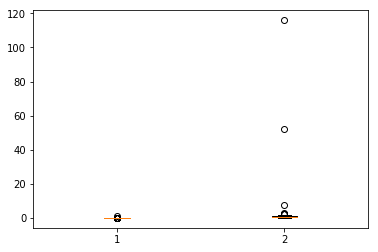

In [15]:
plt.boxplot([delta_list_clean,delta_list3_clean])

0.0290055986015 1.57985037223


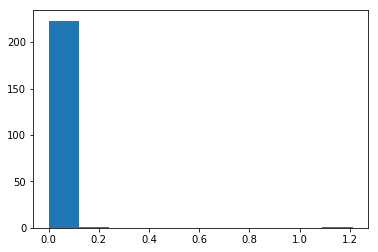

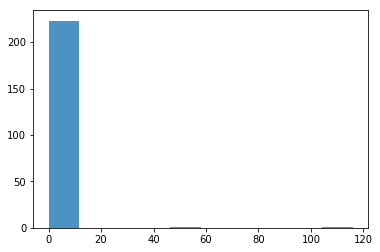

In [16]:
plt.figure()
plt.hist(delta_list_clean)
plt.figure()
plt.hist(delta_list3_clean,alpha=0.8)
print(delta_list_clean.mean(),delta_list3_clean.mean())

{'boxes': [<matplotlib.lines.Line2D at 0x127798198>,
 'caps': [<matplotlib.lines.Line2D at 0x1277fdbe0>,
 'fliers': [<matplotlib.lines.Line2D at 0x127802dd8>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1278025c0>,
 'whiskers': [<matplotlib.lines.Line2D at 0x127798b70>,
  <matplotlib.lines.Line2D at 0x12780fcf8>]}

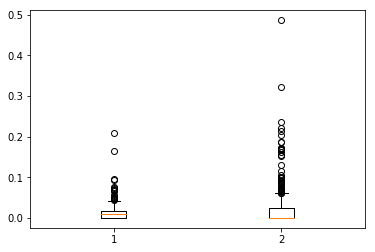

In [17]:
plt.boxplot([beta_list_clean,beta_list3_clean])

(array([ 181.,   21.,    7.,   10.,    4.,    0.,    1.,    0.,    0.,    1.]),
 array([  2.10038573e-09,   4.86154494e-02,   9.72308966e-02,
          1.45846344e-01,   1.94461791e-01,   2.43077238e-01,
          2.91692686e-01,   3.40308133e-01,   3.88923580e-01,
          4.37539028e-01,   4.86154475e-01]),
 <a list of 10 Patch objects>)

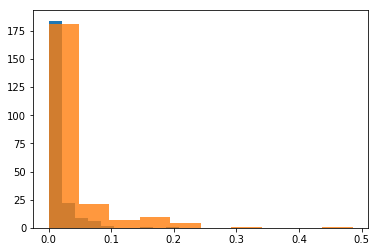

In [18]:
plt.hist(beta_list_clean)
plt.hist(beta_list3_clean,alpha=0.8)

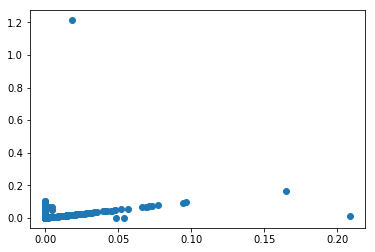

In [19]:
plt.plot(beta_list_clean,delta_list_clean,"o")

{'boxes': [<matplotlib.lines.Line2D at 0x1277612b0>],
 'caps': [<matplotlib.lines.Line2D at 0x1276df748>,
 'fliers': [<matplotlib.lines.Line2D at 0x127651518>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x127651400>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1277614a8>,
  <matplotlib.lines.Line2D at 0x127644b00>]}

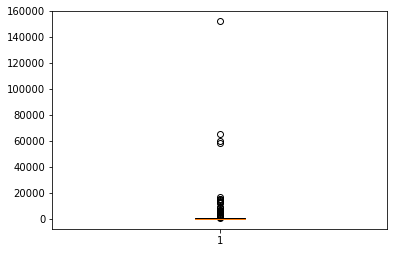

In [20]:
error_delta = delta_std_list_clean/delta_list_clean
plt.boxplot(error_delta)

{'boxes': [<matplotlib.lines.Line2D at 0x1267ba0b8>,
 'caps': [<matplotlib.lines.Line2D at 0x1271313c8>,
 'fliers': [<matplotlib.lines.Line2D at 0x12712c470>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x12712cac8>,
 'whiskers': [<matplotlib.lines.Line2D at 0x1267bae48>,
  <matplotlib.lines.Line2D at 0x1267a2c88>]}

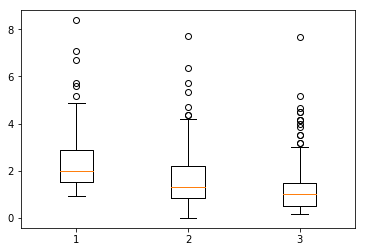

In [21]:
plt.boxplot([t0_list_clean,t0_list3_clean,t0cluster_list])

2.37208065207
1.64052472444
1.23407407407


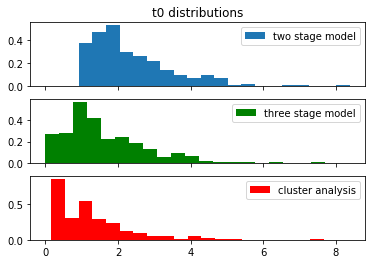

In [22]:
plt.figure()
# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(3, sharex=True)
axarr[0].hist(t0_list_clean, bins=20,normed=True,label='two stage model')
axarr[0].set_title('t0 distributions')
axarr[0].legend()
axarr[1].hist(t0_list3_clean,bins=20,color='g',normed=True,label='three stage model')
axarr[1].legend()
axarr[2].hist(t0cluster_list,bins=20,color='r',normed=True,label='cluster analysis')
axarr[2].legend()
print(t0_list_clean.mean())
print(t0_list3_clean.mean())
print(t0cluster_list.mean())

In [23]:
# save data
np.save("ddc_t0_two",t0_list_clean)
np.save("ddc_t0_three",t0_list3_clean)
np.save("ddc_t0_cluster",t0cluster_list)

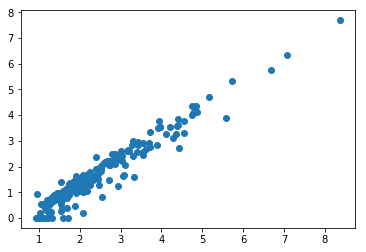

In [24]:
plt.plot(t0_list_clean,t0_list3_clean,"o")

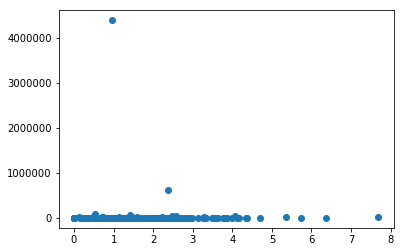

In [25]:
# is onset time correlated with amplitude k_TL?  Seems not
plt.plot(t0_list3,ktl_list3,"o")